In [1]:
from scipy.optimize import fmin_cg, minimize
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import numpy as np

In [2]:
def displayData(X, example_width = None):
    #DISPLAYDATA Display 2D data in a nice grid
    #   [h, display_array] = DISPLAYDATA(X, example_width) displays 2D data
    #   stored in X in a nice grid. It returns the figure handle h and the 
    #   displayed array if requested.

    # Set example_width automatically if not passed in
    if not example_width:
        example_width = int(round(np.sqrt(X.shape[1])))

    # Compute rows, cols
    m, n = X.shape
    example_height = int(n / example_width)

    # Compute number of items to display
    display_rows = int(np.floor(np.sqrt(m)))
    display_cols = int(np.ceil(m / display_rows))

    # Between images padding
    pad = 1

    # Setup blank display
    display_array = - np.ones((pad + display_rows * (example_height + pad), 
                            pad + display_cols * (example_width + pad)))
    
    # Copy each example into a patch on the display array
    curr_ex = 1;
    for j in range(display_rows):
        for i in range(display_cols):
            if curr_ex >= m:
                break
            
            # Copy the patch

            # Get the max value of the patch
            max_val = max(abs(X[curr_ex, :]));
            ind1 = pad + (j - 1) * (example_height + pad) + np.arange(example_height)
            ind2 = pad + (i - 1) * (example_width + pad) + np.arange(example_width)
            
            display_array[np.ix_(ind1, ind2)] = np.reshape(X[curr_ex, :], (example_height, example_width)) / max_val
            curr_ex = curr_ex + 1
        if curr_ex >= m:
            break; 

    # Plot the grid
    plt.imshow(np.transpose(display_array))

In [3]:
def computeNumericalGradient(J, theta):
    #COMPUTENUMERICALGRADIENT Computes the gradient using "finite differences"
    #and gives us a numerical estimate of the gradient.
    #   numgrad = COMPUTENUMERICALGRADIENT(J, theta) computes the numerical
    #   gradient of the function J around theta. Calling y = J(theta) should
    #   return the function value at theta.

    # Notes: The following code implements numerical gradient checking, and
    #        returns the numerical gradient.It sets numgrad(i) to (a numerical
    #        approximation of) the partial derivative of J with respect to the
    #        i-th input argument, evaluated at theta. (i.e., numgrad(i) should
    #        be the (approximately) the partial derivative of J with respect
    #        to theta(i).)
    #

    numgrad = np.zeros(theta.shape)
    perturb = np.zeros(theta.shape)

    e = 1e-4

    for p in range(theta.size):

        # Set perturbation vector
        perturb[p] = e
        loss1, _ = J(theta - perturb)
        loss2, _ = J(theta + perturb)

        # Compute Numerical Gradient
        numgrad[p] = (loss2 - loss1) / (2*e)
        perturb[p] = 0

    return numgrad

In [4]:
def debugInitializeWeights(fan_out, fan_in):
    #DEBUGINITIALIZEWEIGHTS Initialize the weights of a layer with fan_in
    #incoming connections and fan_out outgoing connections using a fixed
    #strategy, this will help you later in debugging
    #   W = DEBUGINITIALIZEWEIGHTS(fan_in, fan_out) initializes the weights
    #   of a layer with fan_in incoming connections and fan_out outgoing
    #   connections using a fix set of values
    #
    #   Note that W should be set to a matrix of size(1 + fan_in, fan_out) as
    #   the first row of W handles the "bias" terms
    #

    # Set W to zeros
    W = np.zeros((fan_out, 1 + fan_in))

    # Initialize W using "sin", this ensures that W is always of the same
    # values and will be useful for debugging
    W = np.reshape(np.sin(range(W.size)), W.shape) / 10

    # =========================================================================

    return W

In [5]:
def checkNNGradients(lambda_par = None):

    #CHECKNNGRADIENTS Creates a small neural network to check the
    #backpropagation gradients
    #   CHECKNNGRADIENTS(lambda) Creates a small neural network to check the
    #   backpropagation gradients, it will output the analytical gradients
    #   produced by your backprop code and the numerical gradients (computed
    #   using computeNumericalGradient). These two gradient computations should
    #   result in very similar values.
    #

    if not lambda_par:
        lambda_par = 0

    input_layer_size = 3
    hidden_layer_size = 5
    num_labels = 3
    m = 5

    # We generate some 'random' test data
    Theta1 = debugInitializeWeights(hidden_layer_size, input_layer_size)
    Theta2 = debugInitializeWeights(num_labels, hidden_layer_size)

    # Reusing debugInitializeWeights to generate X
    X  = debugInitializeWeights(m, input_layer_size - 1)
    y  = 1 + np.transpose(np.remainder( range(m), num_labels))

    # Unroll parameters
    nn_params = np.concatenate((Theta1.ravel(), Theta2.ravel()), axis=0)

    # Short hand for cost function
    costFunc = lambda p : nnCostFunction(p, input_layer_size, hidden_layer_size, num_labels, X, y, lambda_par)

    cost, grad = costFunc(nn_params)
    numgrad = computeNumericalGradient(costFunc, nn_params)

    # Visually examine the two gradient computations.  The two columns
    # you get should be very similar.
    print (np.transpose(np.vstack((numgrad, grad))))
    print ('The above two columns you get should be very similar.\n')
    print ('(Left-Your Numerical Gradient, Right-Analytical Gradient)\n\n')

    # Evaluate the norm of the difference between two solutions.
    # If you have a correct implementation, and assuming you used EPSILON = 0.0001
    # in computeNumericalGradient.m, then diff below should be less than 1e-9
    diff = np.linalg.norm(numgrad-grad)/np.linalg.norm(numgrad+grad);

    print ('If your backpropagation implementation is correct, then \n')
    print ('the relative difference will be small (less than 1e-9). \n')
    print ('\nRelative Difference: \n', diff)

In [6]:
def randInitializeWeights(L_in, L_out):
    #RANDINITIALIZEWEIGHTS Randomly initialize the weights of a layer with L_in
    #incoming connections and L_out outgoing connections
    #   W = RANDINITIALIZEWEIGHTS(L_in, L_out) randomly initializes the weights 
    #   of a layer with L_in incoming connections and L_out outgoing 
    #   connections. 
    #
    #   Note that W should be set to a matrix of size(L_out, 1 + L_in) as
    #   the first row of W handles the "bias" terms
    #

    # You need to return the following variables correctly 
    W = np.zeros((L_out, 1 + L_in));

    # Instructions: Initialize W randomly so that we break the symmetry while
    #               training the neural network.
    #
    # Note: The first row of W corresponds to the parameters for the bias units
    #

    epsilon_init = 0.12; 
    W = (np.random.rand(L_out, L_in + 1) * 2 * epsilon_init) - epsilon_init; 

    # =========================================================================

    return W

In [7]:
def sigmoid(z):
    #SIGMOID Compute sigmoid functoon
    #  G = SIGMOID(z) computes the sigmoid of z.

    g = 1. / (1. + np.exp(-z));
    
    return g

In [8]:
def sigmoidGradient(z):
    #SIGMOIDGRADIENT returns the gradient of the sigmoid function
    #evaluated at z
    #   g = SIGMOIDGRADIENT(z) computes the gradient of the sigmoid function
    #   evaluated at z. This should work regardless if z is a matrix or a
    #   vector. In particular, if z is a vector or matrix, you should return
    #   the gradient for each element.

    g = np.zeros(z.shape);

    # ====================== YOUR CODE HERE ======================
    # Instructions: Compute the gradient of the sigmoid function evaluated at
    #               each value of z (z can be a matrix, vector or scalar).

    
    g=sigmoid(z)*(1-sigmoid(z))

    # =============================================================

    return g


In [9]:
def predict(Theta1, Theta2, X):
    #PREDICT Predict the label of an input given a trained neural network
    #   p = PREDICT(Theta1, Theta2, X) outputs the predicted label of X given the
    #   trained weights of a neural network (Theta1, Theta2)

    # Useful values
    m = X.shape[0]
    num_labels = Theta2.shape[0]

    # You need to return the following variables correctly
    p = np.zeros((X.shape[0], 1))

    # ====================== YOUR CODE HERE ======================
    # Instructions: Complete the following code to make predictions using
    #               your learned neural network. You should set p to a
    #               vector containing labels between 1 to num_labels.
    #
    # Hint: The numpy argmax function might come in useful to return the index of the max element. In particular, the max

    
    a1 = X
    a1 = np.insert(a1, 0, 1, axis=1)
    z2 = np.dot(a1,np. transpose(Theta1))
    a2 = sigmoid(z2)
    a2 = np.insert(a2, 0, 1, axis=1)
    z3 = np.dot(a2,np. transpose(Theta2))
    a3 = sigmoid(z3)
    p = np.argmax(a3, axis=1)

    # =========================================================================

    return p+1 #beacuse indexing starts at 0


In [10]:
def nnCostFunction(nn_params, input_layer_size, hidden_layer_size, num_labels, X, y, lambda_par):
    #NNCOSTFUNCTION Implements the neural network cost function for a two layer
    #neural network which performs classification
    #   [J grad] = NNCOSTFUNCTON(nn_params, hidden_layer_size, num_labels, ...
    #   X, y, lambda_par) computes the cost and gradient of the neural network. The
    #   parameters for the neural network are "unrolled" into the vector
    #   nn_params and need to be converted back into the weight matrices. 
    # 
    #   The returned parameter grad should be a "unrolled" vector of the
    #   partial derivatives of the neural network.
    #

    # Reshape nn_params back into the parameters Theta1 and Theta2, the weight matrices
    # for our 2 layer neural network
    Theta1 = np.reshape(nn_params[0:hidden_layer_size * (input_layer_size + 1)],
                        (hidden_layer_size, (input_layer_size + 1) ))

    Theta2 = np.reshape(nn_params[(hidden_layer_size * (input_layer_size + 1)):],
                        (num_labels, (hidden_layer_size + 1)) )

    # Setup some useful variables
    m = X.shape[0]

    # You need to return the following variables correctly 
    J = 0.0
    Theta1_grad = np.zeros(Theta1.shape)
    Theta2_grad = np.zeros(Theta2.shape)

    # ====================== YOUR CODE HERE ======================
    # Instructions: You should complete the code by working through the
    #               following parts.
    #
    # Part 1: Feedforward the neural network and return the cost in the
    #         variable J. After implementing Part 1, you can verify that your
    #         cost function computation is correct by verifying the cost
    #         computed in main.py
    a1 = X
    a1 = np.insert(a1, 0, 1, axis=1)
    z2 = np.dot(a1,np. transpose(Theta1))
    a2 = sigmoid(z2)
    a2 = np.insert(a2, 0, 1, axis=1)
    z3 = np.dot(a2,np. transpose(Theta2))
    a3 = sigmoid(z3)
    #to convert y to a matric m*k which k is the number of labels and m is number of training data
    y_copy=y
    y = np.zeros((m,num_labels))
    for i in range(m):
        y[i, int(y_copy[i]-1)] = 1
        J += np.sum(-y[i]*np.log(a3[i]) - (1-y[i])*np.log(1-a3[i]))
        
    #not regularizing the first column that is bias    
    sum_Theta1 = np.sum(np.sum(Theta1[:,1:]**2))
    sum_Theta2 = np.sum(np.sum(Theta2[:,1:]**2))
    J = J/m + ((lambda_par/(2.0*m))*(sum_Theta1+sum_Theta2))

    # Part 2: Implement the backpropagation algorithm to compute the gradients
    #         Theta1_grad and Theta2_grad. You should return the partial derivatives of
    #         the cost function with respect to Theta1 and Theta2 in Theta1_grad and
    #         Theta2_grad, respectively. After implementing Part 2, you can check
    #         that your implementation is correct by running checkNNGradients
    #
    #         Note: The vector y passed into the function is a vector of labels
    #               containing values from 1..K. You need to map this vector into a 
    #               binary vector of 1's and 0's to be used with the neural network
    #               cost function.
    #
    #         Hint: We recommend implementing backpropagation using a for-loop
    #               over the training examples if you are implementing it for the 
    #               first time.
    #
    #delta_3=a3-y
    #delta_2=(np.dot(delta_3,Theta2[:,1:]))*sigmoidGradient(z2)
    #delta_2=(np.dot(delta_3,Theta2[:,1:]))*sigmoidGradient(z2)
    #remove δ0

    
    #delta1=np.dot(a1.T,delta_2)
    #delta2=np.dot(a2.T,delta_3)

    
    #Theta1_grad=delta1/m
    #Theta2_grad=delta2/m
    
    # Part 3: Implement regularization with the cost function and gradients.
    #
    #         Hint: You can implement this around the code for
    #               backpropagation. That is, you can compute the gradients for
    #               the regularization separately and then add them to Theta1_grad
    #               and Theta2_grad from Part 2.
    #

    #gradient_regularization_term1= (lambda_par / m) * Theta1.T
    #gradient_regularization_term2= (lambda_par / m) * Theta2.T
    #Theta1_grad+=gradient_regularization_term1
    #Theta2_grad+=gradient_regularization_term2

    # =========================================================================
    delta1=0
    delta2=0
    for i in range(m):
        x=X[i]
        delta_3 = (a3[i] - y[i]).reshape(-1,1)
        delta_2=np.dot(Theta2[:,1:].T,delta_3)*sigmoidGradient(z2[i].reshape(-1,1))
        delta1+=np.dot(delta_2,a1[i].reshape(-1, 1).T)
        delta2+=np.dot(delta_3,a2[i].reshape(1,-1))

    Theta1_grad=delta1/m
    Theta2_grad=delta2/m
    gradient_regularization_term1= (lambda_par / m) * Theta1.T
    gradient_regularization_term2= (lambda_par / m) * Theta2.T
    Theta1_grad+=gradient_regularization_term1.T
    Theta2_grad+=gradient_regularization_term2.T
    # Unroll gradients
    grad = np.concatenate((Theta1_grad.ravel(), Theta2_grad.ravel()), axis=0)
    

    return J, grad

In [11]:
## Initialization

## Setup the parameters you will use for this exercise
input_layer_size  = 400  # 20x20 Input Images of Digits
hidden_layer_size = 25   # 25 hidden units
num_labels = 10          # 10 labels, from 1 to 10   
                          # (note that we have mapped "0" to label 10)


Loading and Visualizing Data ...



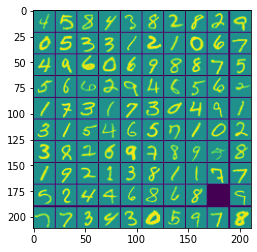

In [12]:
## =========== Part 1: Loading and Visualizing Data =============
#  We start the exercise by first loading and visualizing the dataset. 
#  You will be working with a dataset that contains handwritten digits.
#

# Load Training Data
print ('Loading and Visualizing Data ...\n')

data = np.array([[float(x) for x in l.split(',')] for l in open('dataset.csv', 'r').readlines()])
X = data[:, 0:-1]
y = data[:,-1]

m = X.shape[0]

# Randomly select 100 data points to display
sel = np.random.choice(m, 100, replace=False)

displayData(X[sel, :])

#input("Program paused. Press enter to continue.\n")



In [13]:
## ================ Part 2: Loading Pameters ================
# In this part of the exercise, we load some pre-initialized 
# neural network parameters.

print ('\nLoading Saved Neural Network Parameters ...\n')

# Load the weights into variables Theta1 and Theta2
Theta1 = np.array([[float(x) for x in l.split(',')] for l in open('sampleTheta1.csv', 'r').readlines()])
Theta2 = np.array([[float(x) for x in l.split(',')] for l in open('sampleTheta2.csv', 'r').readlines()])

# Unroll parameters 
nn_params = np.concatenate((Theta1.ravel(), Theta2.ravel()), axis=0)




Loading Saved Neural Network Parameters ...



In [14]:
## ================ Part 3: Compute Cost (Feedforward) ================
#  To the neural network, you should first start by implementing the
#  feedforward part of the neural network that returns the cost only. You
#  should complete the code in nnCostFunction.py to return cost. After
#  implementing the feedforward to compute the cost, you can verify that
#  your implementation is correct by verifying that you get the same cost
#  as us for the fixed debugging parameters.
#
#  We suggest implementing the feedforward cost *without* regularization
#  first so that it will be easier for you to debug. Later, in part 4, you
#  will get to implement the regularized cost.
#
print ('\nFeedforward Using Neural Network ...\n')

# Weight regularization parameter (we set this to 0 here).
lambda_par = 0

J, _ = nnCostFunction(nn_params, input_layer_size, hidden_layer_size, num_labels, X, y, lambda_par)

print ('Cost at parameters (loaded from sampleTheta1 and sampleTheta2):', J, '\n(this value should be about 0.287629)\n')


#input("Program paused. Press enter to continue.\n")



Feedforward Using Neural Network ...

Cost at parameters (loaded from sampleTheta1 and sampleTheta2): 0.2876291653573187 
(this value should be about 0.287629)



In [15]:
## =============== Part 4: Implement Regularization ===============
#  Once your cost function implementation is correct, you should now
#  continue to implement the regularization with the cost.
#

print ('\nChecking Cost Function with Regularization ... \n')

# Weight regularization parameter (we set this to 1 here).
lambda_par = 1.

J, _ = nnCostFunction(nn_params, input_layer_size, hidden_layer_size, num_labels, X, y, lambda_par)

print ('Cost at parameters (loaded from sampleTheta1 and sampleTheta2):', J, '\n(this value should be about 0.383770)\n')

#input("Program paused. Press enter to continue.\n")





Checking Cost Function with Regularization ... 

Cost at parameters (loaded from sampleTheta1 and sampleTheta2): 0.383769859289297 
(this value should be about 0.383770)



In [16]:
## ================ Part 5: Sigmoid Gradient  ================
#  Before you start implementing the neural network, you will first
#  implement the gradient for the sigmoid function. You should complete the
#  code in the sigmoidGradient.py file.
#

print ('\nEvaluating sigmoid gradient...\n')

g = sigmoidGradient(np.array([-1, -0.5, 0, 0.5, 1]))
print ('Sigmoid gradient evaluated at [-1 -0.5 0 0.5 1]:\n  ')
print (g)
print ('\n\n')

#input("Program paused. Press enter to continue.\n")




Evaluating sigmoid gradient...

Sigmoid gradient evaluated at [-1 -0.5 0 0.5 1]:
  
[0.19661193 0.23500371 0.25       0.23500371 0.19661193]





In [17]:
## ================ Part 6: Initializing Pameters ================
#  In this part of the exercise, you will be starting to implment a two
#  layer neural network that classifies digits. You will start by
#  implementing a function to initialize the weights of the neural network
#  (randInitializeWeights.py)

print ('\nInitializing Neural Network Parameters ...\n')

initial_Theta1 = randInitializeWeights(input_layer_size, hidden_layer_size);
initial_Theta2 = randInitializeWeights(hidden_layer_size, num_labels);

# Unroll parameters
initial_nn_params = np.concatenate((initial_Theta1.ravel(), initial_Theta2.ravel()), axis=0)




Initializing Neural Network Parameters ...



In [18]:
## =============== Part 7: Implement Backpropagation ===============
#  Once your cost matches up with ours, you should proceed to implement the
#  backpropagation algorithm for the neural network. You should add to the
#  code you've written in nnCostFunction.py to return the partial
#  derivatives of the parameters.
#
print ('\nChecking Backpropagation... \n')

#  Check gradients by running checkNNGradients
checkNNGradients()

#input("Program paused. Press enter to continue.\n")





Checking Backpropagation... 

[[ 6.90654083e-03  6.90654084e-03]
 [-1.10852709e-04 -1.10852710e-04]
 [ 1.43851837e-04  1.43851834e-04]
 [ 2.66299665e-04  2.66299665e-04]
 [ 1.21251043e-02  1.21251043e-02]
 [-4.29822000e-05 -4.29822018e-05]
 [ 1.51666186e-04  1.51666187e-04]
 [ 2.06873381e-04  2.06873383e-04]
 [ 6.19847901e-03  6.19847902e-03]
 [ 6.41872688e-05  6.41872658e-05]
 [ 2.03012229e-05  2.03012235e-05]
 [-4.22496704e-05 -4.22496701e-05]
 [-5.42355683e-03 -5.42355683e-03]
 [ 1.12549716e-04  1.12549718e-04]
 [-1.30018476e-04 -1.30018475e-04]
 [-2.53048280e-04 -2.53048282e-04]
 [-1.20761029e-02 -1.20761029e-02]
 [ 5.72000558e-05  5.72000571e-05]
 [-1.60500355e-04 -1.60500356e-04]
 [-2.30637482e-04 -2.30637482e-04]
 [ 1.02286353e-01  1.02286353e-01]
 [ 5.09594910e-02  5.09594910e-02]
 [ 4.96506204e-02  4.96506204e-02]
 [ 5.32772700e-02  5.32772700e-02]
 [ 4.98448914e-02  4.98448914e-02]
 [ 5.07054723e-02  5.07054723e-02]
 [ 9.95931723e-02  9.95931723e-02]
 [ 5.02316727e-02  5.023

In [19]:
## =============== Part 8: Implement Regularization ===============
#  Once your backpropagation implementation is correct, you should now
#  continue to implement the regularization with the cost and gradient.
#

print ('\nChecking Backpropagation with Regularization ... \n')

#  Check gradients by running checkNNGradients
lambda_par = 3.
checkNNGradients(lambda_par)

# Also output the costFunction debugging values
debug_J, _  = nnCostFunction(nn_params, input_layer_size, hidden_layer_size, num_labels, X, y, lambda_par)

print ('\n\nCost at (fixed) debugging parameters (with lambda = 3): ', debug_J, '\n(this value should be about 0.576051)\n\n')

#input("Program paused. Press enter to continue.\n")



Checking Backpropagation with Regularization ... 

[[ 0.00690654  0.00690654]
 [ 0.05037741  0.05037741]
 [ 0.0547017   0.0547017 ]
 [ 0.0087335   0.0087335 ]
 [ 0.0121251  -0.03328305]
 [-0.05757844 -0.05757844]
 [-0.01661326 -0.01661326]
 [ 0.03962607  0.03962607]
 [ 0.00619848  0.06555997]
 [ 0.0247913   0.0247913 ]
 [-0.03262097 -0.03262097]
 [-0.06004166 -0.06004166]
 [-0.00542356 -0.03761793]
 [ 0.02532257  0.02532257]
 [ 0.05930642  0.05930642]
 [ 0.03876422  0.03876422]
 [-0.0120761  -0.0293503 ]
 [-0.05762665 -0.05762665]
 [-0.04521974 -0.04521974]
 [ 0.008762    0.008762  ]
 [ 0.10228635  0.10228635]
 [ 0.10144775  0.10144775]
 [ 0.10420847  0.10420847]
 [ 0.06174447  0.06174447]
 [ 0.00443674  0.00443674]
 [-0.00682998 -0.00682998]
 [ 0.09959317  0.08282824]
 [ 0.08965087  0.08965087]
 [ 0.10720022  0.10720022]
 [ 0.07664811  0.07664811]
 [ 0.01633527  0.01633527]
 [-0.01125638 -0.01125638]
 [ 0.29693242  0.26473805]
 [ 0.17354254  0.17354254]
 [ 0.20209208  0.20209208]
 [ 

In [20]:
## =================== Part 9: Training NN ===================
#  You have now implemented all the code necessary to train a neural
#  network. To train your neural network, we will now use "fmincg", which
#  is a function which works similarly to "fminunc". Recall that these
#  advanced optimizers are able to train our cost functions efficiently as
#  long as we provide them with the gradient computations.
#
print ('\nTraining Neural Network... \n')

#  After you have completed the assignment, change the MaxIter to a larger
#  value to see how more training helps.
#options = optimset('MaxIter', 50)

#  You should also try different values of lambda
lambda_par = 1.

# Create "short hand" for the cost function to be minimized
costFunction = lambda p: nnCostFunction(p, input_layer_size, hidden_layer_size, num_labels, X, y, lambda_par)[0]
gradientFunction = lambda p: nnCostFunction(p, input_layer_size, hidden_layer_size, num_labels, X, y, lambda_par)[1]

# Now, costFunction is a function that takes in only one argument (the
# neural network parameters)
Nfeval = 1
def callbackF(Xi):
    global Nfeval
    print (Nfeval)
    Nfeval += 1


nn_params = fmin_cg(costFunction, initial_nn_params, fprime=gradientFunction, maxiter=50, disp=True, callback=callbackF)


# Obtain Theta1 and Theta2 back from nn_params
Theta1 = np.reshape(nn_params[range(hidden_layer_size * (input_layer_size + 1))], (hidden_layer_size, (input_layer_size + 1)))

Theta2 = np.reshape(nn_params[(hidden_layer_size * (input_layer_size + 1)):], (num_labels, (hidden_layer_size + 1)))

#input("Program paused. Press enter to continue.\n")




Training Neural Network... 

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
         Current function value: 0.445482
         Iterations: 50
         Function evaluations: 100
         Gradient evaluations: 100



Visualizing Neural Network... 



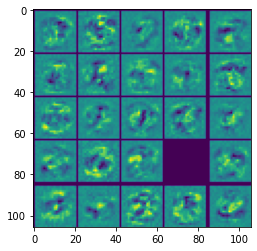

In [21]:
## ================= Part 10: Visualize Weights =================
#  You can now "visualize" what the neural network is learning by
#  displaying the hidden units to see what features they are capturing in
#  the data.

print ('\nVisualizing Neural Network... \n')

displayData(Theta1[:, 1:])

#input("Program paused. Press enter to continue.\n")



In [22]:
## ================= Part 11: Implement Predict =================
#  After training the neural network, we would like to use it to predict
#  the labels. You will now implement the "predict" function to use the
#  neural network to predict the labels of the training set. This lets
#  you compute the training set accuracy.

pred = predict(Theta1, Theta2, X)

print ('\nTraining Set Accuracy:', accuracy_score(y, pred))




Training Set Accuracy: 0.9624
